In [1]:
import sys
sys.path.append("..")
import download_utils

In [2]:
download_utils.link_all_keras_resources()

In [3]:
import tensorflow as tf
from tensorflow.contrib import keras
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
L = keras.layers
K = keras.backend
import tqdm
import utils
import time
import zipfile
import json
from collections import defaultdict
import re
import random
from random import choice
import grading_utils
import os

In [6]:
IMG_SIZE = 299

In [7]:
# we take the last hidden layer of IncetionV3 as an image embedding
def get_cnn_encoder():
    K.set_learning_phase(False)
    model = keras.applications.InceptionV3(include_top=False)
    preprocess_for_model = keras.applications.inception_v3.preprocess_input

    model = keras.models.Model(model.inputs, keras.layers.GlobalAveragePooling2D()(model.output))
    return model, preprocess_for_model

In [8]:
# load prepared embeddings
train_img_embeds = utils.read_pickle("train_img_embeds.pickle")
train_img_fns = utils.read_pickle("train_img_fns.pickle")
val_img_embeds = utils.read_pickle("val_img_embeds.pickle")
val_img_fns = utils.read_pickle("val_img_fns.pickle")
# check shapes
print(train_img_embeds.shape, len(train_img_fns))
print(val_img_embeds.shape, len(val_img_fns))

(82783, 2048) 82783
(40504, 2048) 40504


In [9]:
# check prepared samples of images
list(filter(lambda x: x.endswith("_sample.zip"), os.listdir(".")))

['val2014_sample.zip', 'train2014_sample.zip']

# Extract captions for images

In [10]:
def get_captions_for_fns(fns, zip_fn, zip_json_path):
    zf = zipfile.ZipFile(zip_fn)
    j = json.loads(zf.read(zip_json_path).decode("utf8"))
    id_to_fn = {img["id"]: img["file_name"] for img in j["images"]}
    fn_to_caps = defaultdict(list)
    for cap in j['annotations']:
        fn_to_caps[id_to_fn[cap['image_id']]].append(cap['caption'])
    fn_to_caps = dict(fn_to_caps)
    return list(map(lambda x: fn_to_caps[x], fns))
    
train_captions = get_captions_for_fns(train_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_train2014.json")

val_captions = get_captions_for_fns(val_img_fns, "captions_train-val2014.zip", 
                                      "annotations/captions_val2014.json")

# check shape
print(len(train_img_fns), len(train_captions))
print(len(val_img_fns), len(val_captions))

82783 82783
40504 40504


In [11]:
train_captions[1]

['A group of zebra standing next to each other.',
 'This is an image of of zebras drinking',
 'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
 'Zebras that are bent over and drinking water together.',
 'a number of zebras drinking water near one another']

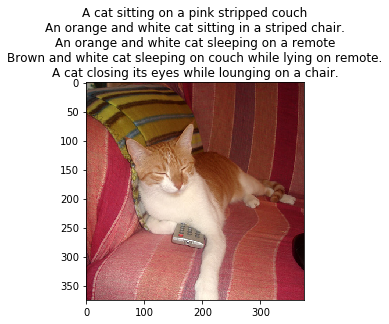

In [12]:
def show_trainig_example(train_img_fns, train_captions, example_idx=0):
    """
    You can change example_idx and see different images
    """
    zf = zipfile.ZipFile("train2014_sample.zip")
    captions_by_file = dict(zip(train_img_fns, train_captions))
    all_files = set(train_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    img = utils.decode_image_from_buf(zf.read(example))
    plt.imshow(utils.image_center_crop(img))
    plt.title("\n".join(captions_by_file[example.filename.rsplit("/")[-1]]))
    plt.show()
    
show_trainig_example(train_img_fns, train_captions, example_idx=142)

# Prepare captions for training

In [13]:
# preview captions data
train_captions[:2]

[['A long dirt road going through a forest.',
  'A SCENE OF WATER AND A PATH WAY',
  'A sandy path surrounded by trees leads to a beach.',
  'Ocean view through a dirt road surrounded by a forested area. ',
  'dirt path leading beneath barren trees to open plains'],
 ['A group of zebra standing next to each other.',
  'This is an image of of zebras drinking',
  'ZEBRAS AND BIRDS SHARING THE SAME WATERING HOLE',
  'Zebras that are bent over and drinking water together.',
  'a number of zebras drinking water near one another']]

In [14]:
from collections import Counter

# special tokens
PAD = "#PAD#"
UNK = "#UNK#"
START = "#START#"
END = "#END#"

def split_sentence(sentence):
    return list(filter(lambda x: len(x) > 0, re.split('\W+', sentence.lower())))

def generate_vocabulary(train_captions):
    vocab = []
    for train_el in train_captions:
        for sent in train_el:
            vocab += split_sentence(sent)
    vocab = Counter(vocab)
    vocab = {k: v for k, v in vocab.items() if v >= 5}
    
    vocab[PAD] = 1
    vocab[UNK] = 1
    vocab[START] = 1
    vocab[END] = 1
    
    return {token: index for index, token in enumerate(sorted(vocab))}
    
def caption_tokens_to_indices(captions, vocab):
    
    def sent_to_ind(sent):
        return [vocab[START]] +\
                [vocab.get(el) if vocab.get(el) is not None else vocab[UNK] for el in split_sentence(sent)] +\
                    [vocab[END]]
            
    def pic_to_ind(pic_captions):
        return [sent_to_ind(sent) for sent in pic_captions]
    
    res = [pic_to_ind(pic_captions) for pic_captions in captions]
    return res

In [15]:
# prepare vocabulary
vocab = generate_vocabulary(train_captions)
vocab_inverse = {idx: w for w, idx in vocab.items()}
print(len(vocab))

8769


In [16]:
# replace tokens with indices
train_captions_indexed = caption_tokens_to_indices(train_captions, vocab)
val_captions_indexed = caption_tokens_to_indices(val_captions, vocab)

In [17]:
train_captions_indexed[0]

[[2, 54, 4462, 2305, 6328, 3354, 7848, 54, 3107, 0],
 [2, 54, 6540, 5127, 8486, 249, 54, 5437, 8507, 0],
 [2, 54, 6502, 5437, 7581, 1124, 8052, 4287, 7905, 54, 639, 0],
 [2, 5120, 8367, 7848, 54, 2305, 6328, 7581, 1124, 54, 3108, 331, 0],
 [2, 2305, 5437, 4286, 710, 587, 8052, 7905, 5174, 5684, 0]]

In [18]:
def batch_captions_to_matrix(batch_captions, pad_idx, max_len=None):
    """
    `batch_captions` is an array of arrays:
    [
        [vocab[START], ..., vocab[END]],
        [vocab[START], ..., vocab[END]],
        ...
    ]
    Put vocabulary indexed captions into np.array of shape (len(batch_captions), columns),
        where "columns" is max(map(len, batch_captions)) when max_len is None
        and "columns" = min(max_len, max(map(len, batch_captions))) otherwise.
    Add padding with pad_idx where necessary.
    Input example: [[1, 2, 3], [4, 5]]
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=None
    Output example: np.array([[1, 2], [4, 5]]) if max_len=2
    Output example: np.array([[1, 2, 3], [4, 5, pad_idx]]) if max_len=100
    Try to use numpy, we need this function to be fast!
    """
    if max_len:
        columns = min(max_len, max(map(len, batch_captions)))
    else:
        columns = max(map(len, batch_captions))
    
    
    matrix = np.ones((len(batch_captions), columns), dtype=np.int32) * pad_idx
    
    for enu, row in enumerate(batch_captions):
        matrix[enu][0:min(columns, len(row))] = row[0:min(columns, len(row))]
        
    return matrix

# Training

In [21]:
IMG_EMBED_SIZE = train_img_embeds.shape[1]
IMG_EMBED_BOTTLENECK = 120
WORD_EMBED_SIZE = 100
LSTM_UNITS = 300
LOGIT_BOTTLENECK = 120
pad_idx = vocab[PAD]

In [22]:
# remember to reset your graph if you want to start building it from scratch!
tf.reset_default_graph()
tf.set_random_seed(42)
s = tf.InteractiveSession()

In [23]:
class decoder:
    img_embeds = tf.placeholder('float32', [None, IMG_EMBED_SIZE])
    sentences = tf.placeholder('int32', [None, None])
    
    img_embed_to_bottleneck = L.Dense(IMG_EMBED_BOTTLENECK, 
                                      input_shape=(None, IMG_EMBED_SIZE), 
                                      activation='elu')
    img_embed_bottleneck_to_h0 = L.Dense(LSTM_UNITS,
                                         input_shape=(None, IMG_EMBED_BOTTLENECK),
                                         activation='elu')
    word_embed = L.Embedding(len(vocab), WORD_EMBED_SIZE)
    lstm = tf.nn.rnn_cell.LSTMCell(LSTM_UNITS)
    

    token_logits_bottleneck = L.Dense(LOGIT_BOTTLENECK, 
                                      input_shape=(None, LSTM_UNITS),
                                      activation="elu")
    token_logits = L.Dense(len(vocab),
                           input_shape=(None, LOGIT_BOTTLENECK))
    
    c0 = h0 = img_embed_bottleneck_to_h0(img_embed_to_bottleneck(img_embeds))
    
    word_embeds = word_embed(sentences[:,:-1])

    hidden_states, _ = tf.nn.dynamic_rnn(lstm, word_embeds,
                                         initial_state=tf.nn.rnn_cell.LSTMStateTuple(c0, h0))

    flat_hidden_states = tf.reshape(hidden_states, shape=(-1, LSTM_UNITS))

    flat_token_logits = token_logits(token_logits_bottleneck(flat_hidden_states))

    # flat_ground_truth = sentences[:,-1]
    flat_ground_truth = tf.reshape(sentences[:, 1:], [-1])
    # flat_ground_truth = tf.one_hot(sentences[:,-1], len(vocab))


    flat_loss_mask = ~tf.equal(flat_ground_truth, pad_idx)
    # flat_loss_mask =~tf.equal(tf.one_hot(pad_idx, len(vocab)), pad_idx)

    xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=flat_ground_truth, 
        logits=flat_token_logits
    )


    loss = tf.reduce_mean(tf.boolean_mask(xent, flat_loss_mask))

In [24]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train_step = optimizer.minimize(decoder.loss)

saver = tf.train.Saver()

# intialize all variables
s.run(tf.global_variables_initializer())

/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


## Training loop

In [26]:
train_captions_indexed = np.array(train_captions_indexed)
val_captions_indexed = np.array(val_captions_indexed)

In [27]:
def generate_batch(images_embeddings, indexed_captions, batch_size, max_len=None):
    """
    `images_embeddings` is a np.array of shape [number of images, IMG_EMBED_SIZE].
    `indexed_captions` holds 5 vocabulary indexed captions for each image:
    [
        [
            [vocab[START], vocab["image1"], vocab["caption1"], vocab[END]],
            [vocab[START], vocab["image1"], vocab["caption2"], vocab[END]],
            ...
        ],
        ...
    ]
    Generate a random batch of size `batch_size`.
    Take random images and choose one random caption for each image.
    Remember to use `batch_captions_to_matrix` for padding and respect `max_len` parameter.
    Return feed dict {decoder.img_embeds: ..., decoder.sentences: ...}.
    """
    inds = np.random.choice(len(images_embeddings), size=batch_size, replace=False)
    assert isinstance(inds, np.ndarray)
    assert len(inds.shape) == 1
    batch_image_embeddings = images_embeddings[inds]
    
#     captions = []
#     for ind in inds:
# #         assert isinstance(indexed_captions[ind], list)
#         caption = np.random.choice(indexed_captions[ind])
# #         assert isinstance(caption, list)
# #         assert len(caption) > 0
# #         assert isinstance(caption[0], int)
#         captions.append(caption)
        
    try:    
        # captions = [np.random.choice(indexed_captions[ind]) for ind in inds]
        captions = [indexed_captions[ind][np.random.choice(5)] for ind in inds]
        batch_captions_matrix = batch_captions_to_matrix(captions, pad_idx, max_len)
    except:
        print("Len inds: ", len(inds))
        for ind in inds:
            print(indexed_captions[ind])
        
    return {decoder.img_embeds: batch_image_embeddings, 
            decoder.sentences: batch_captions_matrix}

In [28]:
batch_size = 64
n_epochs = 12
n_batches_per_epoch = 1000
n_validation_batches = 100  

In [29]:
saver.restore(s, os.path.abspath("weights"))

INFO:tensorflow:Restoring parameters from /home/jovyan/work/week6/weights


In [ ]:
MAX_LEN = 20  

np.random.seed(42)
random.seed(42)

for epoch in range(n_epochs):
    
    train_loss = 0
    pbar = tqdm.tqdm_notebook(range(n_batches_per_epoch))
    counter = 0
    for _ in pbar:
        train_loss += s.run([decoder.loss, train_step], 
                            generate_batch(train_img_embeds, 
                                           train_captions_indexed, 
                                           batch_size, 
                                           MAX_LEN))[0]
        counter += 1
        pbar.set_description("Training loss: %f" % (train_loss / counter))
        
    train_loss /= n_batches_per_epoch
    
    val_loss = 0
    for _ in range(n_validation_batches):
        val_loss += s.run(decoder.loss, generate_batch(val_img_embeds,
                                                       val_captions_indexed, 
                                                       batch_size, 
                                                       MAX_LEN))
    val_loss /= n_validation_batches
    
    print('Epoch: {}, train loss: {}, val loss: {}'.format(epoch, train_loss, val_loss))

    # save weights after finishing epoch
    saver.save(s, os.path.abspath("weights_{}".format(epoch)))
    
print("Finished!")



Epoch: 0, train loss: 4.31184641957283, val loss: 3.6578121280670164


In [30]:
from sklearn.metrics import accuracy_score, log_loss

def decode_sentence(sentence_indices):
    return " ".join(list(map(vocab_inverse.get, sentence_indices)))

def check_after_training(n_examples):
    fd = generate_batch(train_img_embeds, train_captions_indexed, batch_size)
    logits = decoder.flat_token_logits.eval(fd)
    truth = decoder.flat_ground_truth.eval(fd)
    mask = decoder.flat_loss_mask.eval(fd).astype(bool)
    print("Loss:", decoder.loss.eval(fd))
    print("Accuracy:", accuracy_score(logits.argmax(axis=1)[mask], truth[mask]))
    for example_idx in range(n_examples):
        print("Example", example_idx)
        print("Predicted:", decode_sentence(logits.argmax(axis=1).reshape((batch_size, -1))[example_idx]))
        print("Truth:", decode_sentence(truth.reshape((batch_size, -1))[example_idx]))
        print("")

check_after_training(3)

Loss: 2.36165
Accuracy: 0.483695652174
Example 0
Predicted: a old woman with bananas bananas and a side #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: an asian market has hanging bananas by the roof #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 1
Predicted: a double bus bus decker bus parked down a street #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a vintage red double decker bus drives down the street #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#

Example 2
Predicted: a man standing a pizza on a in on #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END# #END#
Truth: a man making a snowboard with wood working tools #END# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD# #PAD#



# Applying model

In [31]:
class final_model:
    # CNN encoder
    encoder, preprocess_for_model = get_cnn_encoder()
    saver.restore(s, os.path.abspath("weights"))  # keras applications corrupt our graph, so we restore trained weights
    
    # containers for current lstm state
    lstm_c = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="cell")
    lstm_h = tf.Variable(tf.zeros([1, LSTM_UNITS]), name="hidden")

    # input images
    input_images = tf.placeholder('float32', [1, IMG_SIZE, IMG_SIZE, 3], name='images')

    # get image embeddings
    img_embeds = encoder(input_images)

    # initialize lstm state conditioned on image
    init_c = init_h = decoder.img_embed_bottleneck_to_h0(decoder.img_embed_to_bottleneck(img_embeds))
    init_lstm = tf.assign(lstm_c, init_c), tf.assign(lstm_h, init_h)
    
    # current word index
    current_word = tf.placeholder('int32', [1], name='current_input')

    # embedding for current word
    word_embed = decoder.word_embed(current_word)

    # apply lstm cell, get new lstm states
    new_c, new_h = decoder.lstm(word_embed, tf.nn.rnn_cell.LSTMStateTuple(lstm_c, lstm_h))[1]

    # compute logits for next token
    new_logits = decoder.token_logits(decoder.token_logits_bottleneck(new_h))
    # compute probabilities for next token
    new_probs = tf.nn.softmax(new_logits)

    # `one_step` outputs probabilities of next token and updates lstm hidden state
    one_step = new_probs, tf.assign(lstm_c, new_c), tf.assign(lstm_h, new_h)

INFO:tensorflow:Restoring parameters from /home/jovyan/work/week6/weights


In [32]:
_ = np.array([0.5, 0.4, 0.1])
for t in [0.01, 0.1, 1, 10, 100]:
    print(" ".join(map(str, _**(1/t) / np.sum(_**(1/t)))), "with temperature", t)

0.999999999796 2.03703597592e-10 1.26765059997e-70 with temperature 0.01
0.903037043325 0.0969628642039 9.24709932365e-08 with temperature 0.1
0.5 0.4 0.1 with temperature 1
0.353447726392 0.345648113606 0.300904160002 with temperature 10
0.335367280481 0.334619764349 0.33001295517 with temperature 100


In [33]:
def generate_caption(image, t=1, sample=False, max_len=20):
    """
    Generate caption for given image.
    if `sample` is True, we will sample next token from predicted probability distribution.
    `t` is a temperature during that sampling,
        higher `t` causes more uniform-like distribution = more chaos.
    """
    # condition lstm on the image
    s.run(final_model.init_lstm, 
          {final_model.input_images: [image]})
    
    # current caption
    # start with only START token
    caption = [vocab[START]]
    
    for _ in range(max_len):
        next_word_probs = s.run(final_model.one_step, 
                                {final_model.current_word: [caption[-1]]})[0]
        next_word_probs = next_word_probs.ravel()
        
        # apply temperature
        next_word_probs = next_word_probs**(1/t) / np.sum(next_word_probs**(1/t))

        if sample:
            next_word = np.random.choice(range(len(vocab)), p=next_word_probs)
        else:
            next_word = np.argmax(next_word_probs)

        caption.append(next_word)
        if next_word == vocab[END]:
            break
       
    return list(map(vocab_inverse.get, caption))

a baseball player swinging a bat at a ball


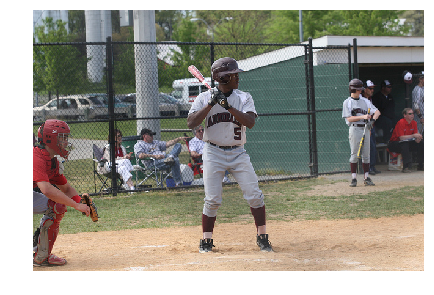

In [34]:
# look at validation prediction example
def apply_model_to_image_raw_bytes(raw):
    img = utils.decode_image_from_buf(raw)
    fig = plt.figure(figsize=(7, 7))
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img)
    img = utils.crop_and_preprocess(img, (IMG_SIZE, IMG_SIZE), final_model.preprocess_for_model)
    print(' '.join(generate_caption(img)[1:-1]))
    plt.show()

def show_valid_example(val_img_fns, example_idx=0):
    zf = zipfile.ZipFile("val2014_sample.zip")
    all_files = set(val_img_fns)
    found_files = list(filter(lambda x: x.filename.rsplit("/")[-1] in all_files, zf.filelist))
    example = found_files[example_idx]
    apply_model_to_image_raw_bytes(zf.read(example))
    
show_valid_example(val_img_fns, example_idx=100)

a bed with a canopy and a white sheet


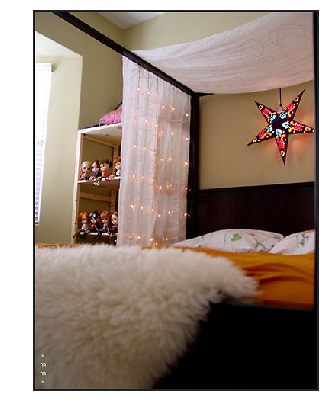

a remote control sitting on a table next to a keyboard


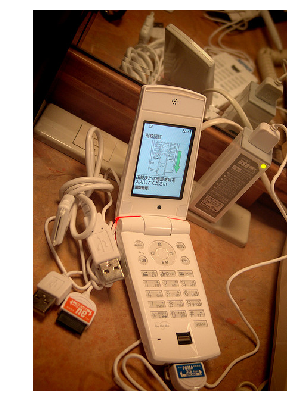

a dog laying on a couch next to a dog


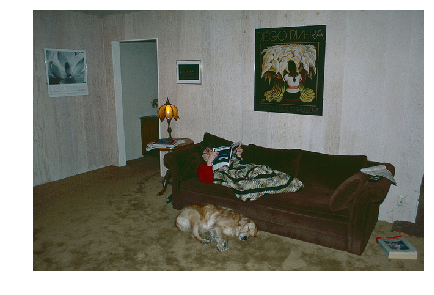

a bathroom with a toilet and a shower


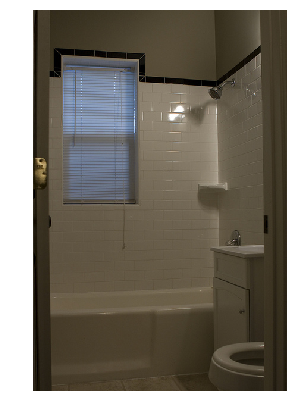

a pizza with cheese and cheese on it


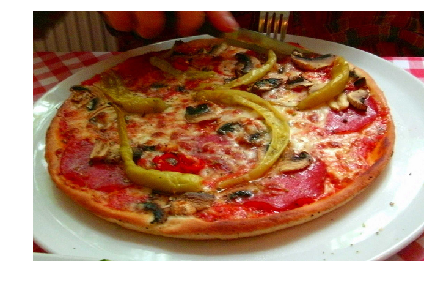

a polar bear swimming in the water with a frisbee


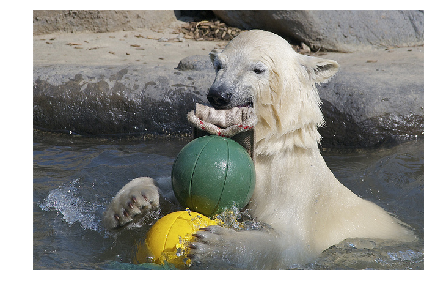

a basket of oranges and a bowl of oranges


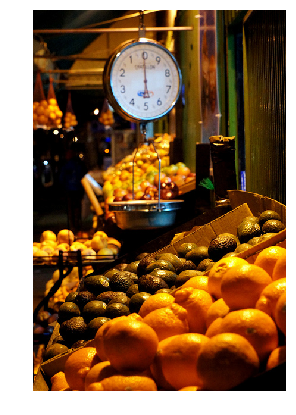

a white plate with a piece of cake on it


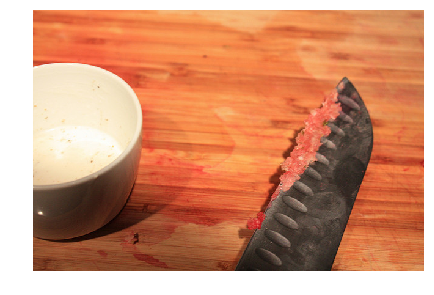

a group of people sitting on a bench in front of a building


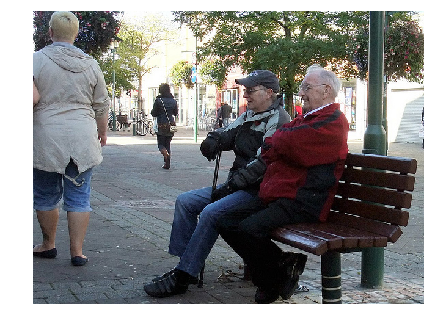

a man riding a skateboard down a street


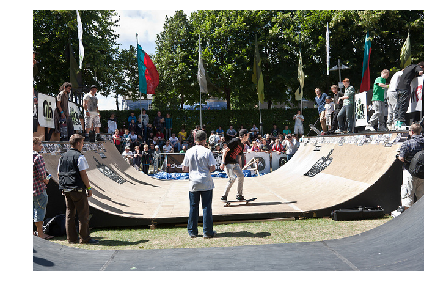

In [35]:
# sample more images from validation
for idx in np.random.choice(range(len(zipfile.ZipFile("val2014_sample.zip").filelist) - 1), 10):
    show_valid_example(val_img_fns, example_idx=idx)
    time.sleep(1)

## Example of good performance

#### 1)

a train is coming down the tracks near a building


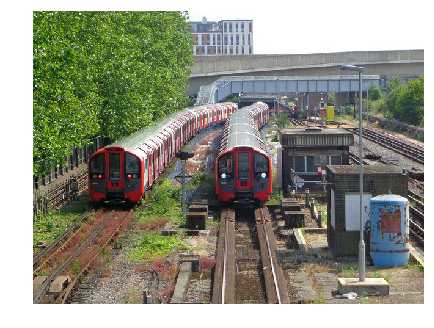

In [38]:
show_valid_example(val_img_fns, example_idx=0)

#### 2)

a large elephant standing next to a tree


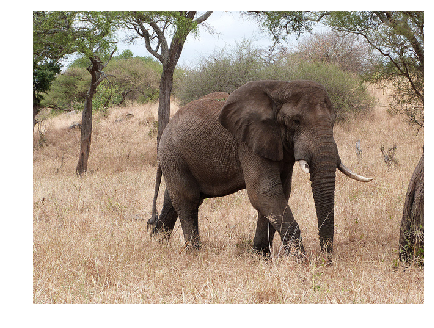

In [41]:
show_valid_example(val_img_fns, example_idx=3)

#### 3)

a bike parked on a sidewalk next to a building


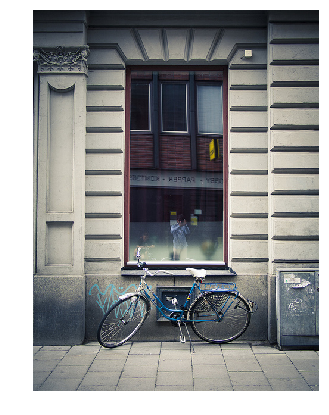

In [45]:
show_valid_example(val_img_fns, example_idx=7)

#### 4)

a group of people sitting on a boat in the water


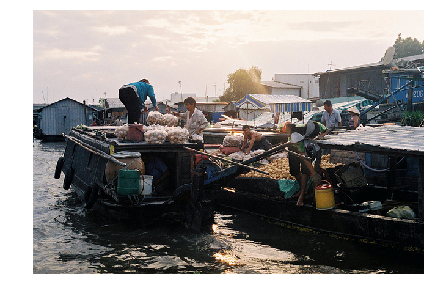

In [49]:
show_valid_example(val_img_fns, example_idx=11)

#### 5)

a pile of vegetables and vegetables on a table


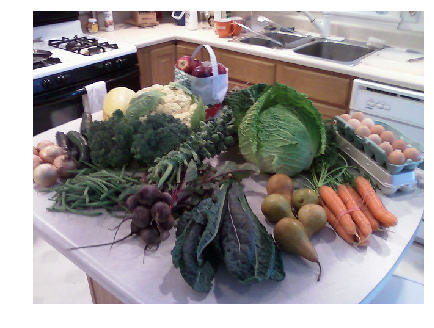

In [52]:
show_valid_example(val_img_fns, example_idx=14)

#### 6)

a white bus parked next to a building


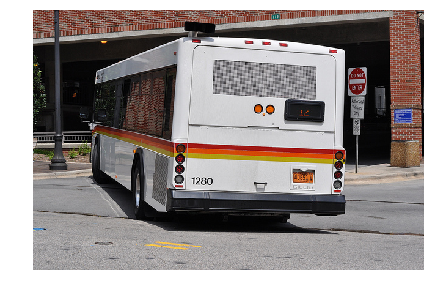

In [54]:
show_valid_example(val_img_fns, example_idx=16)

#### 7)

a man sitting at a table with a laptop computer


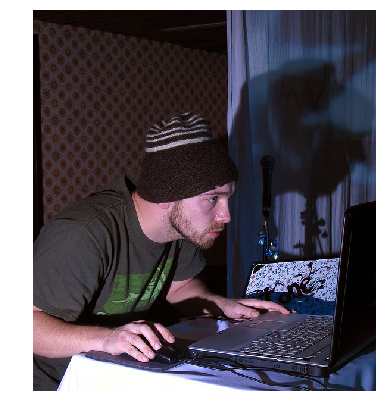

In [56]:
show_valid_example(val_img_fns, example_idx=18)

#### 8)

a man riding a wave on a surfboard


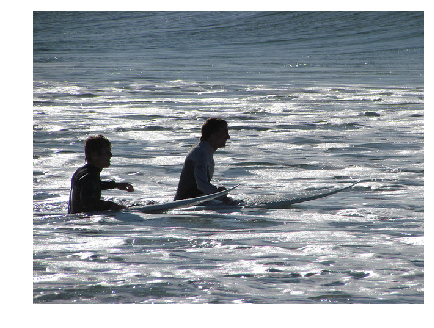

In [57]:
show_valid_example(val_img_fns, example_idx=19)

#### 9)

a person skiing down a snowy hill


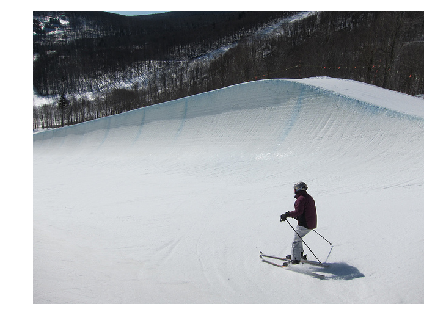

In [58]:
show_valid_example(val_img_fns, example_idx=20)

#### 10)

a giraffe standing in a field with trees in the background


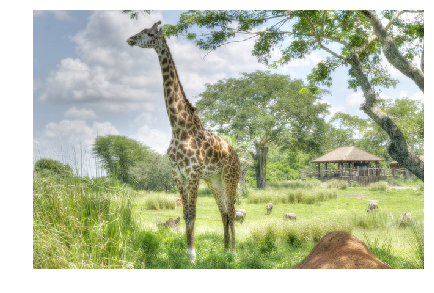

In [64]:
show_valid_example(val_img_fns, example_idx=26)

## Examples of not-good performance

#### 1)

a white and white clock sitting on a white wall


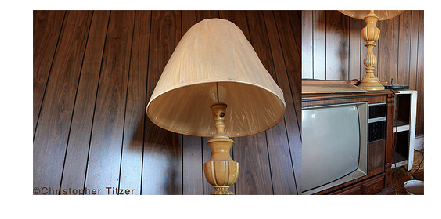

In [66]:
show_valid_example(val_img_fns, example_idx=23)

#### 2)

a man riding a bike down a road with a dog on it


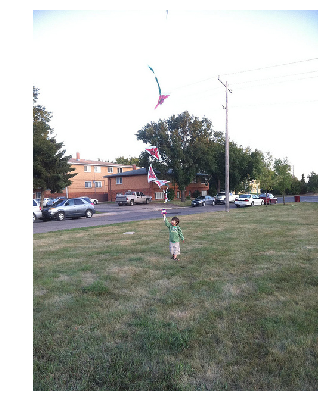

In [90]:
show_valid_example(val_img_fns, example_idx=49)

#### 3)

a young boy holding a baseball bat in a field


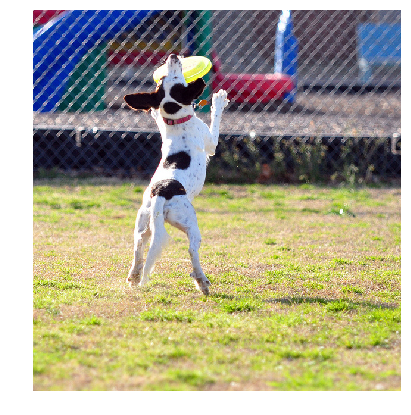

In [96]:
show_valid_example(val_img_fns, example_idx=55)

#### 4)

a bathroom with a sink and a mirror


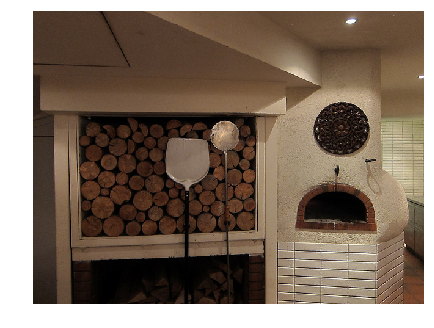

In [105]:
show_valid_example(val_img_fns, example_idx=64)

#### 5)

a room with a bed and a chair


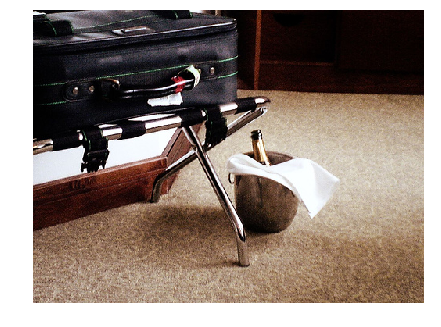

In [128]:
show_valid_example(val_img_fns, example_idx=89)

#### 6)

--2018-06-03 09:40:31--  https://cdn.ndtv.com/tech/images/gadgets/pikachu_hi_pokemon.jpg
Resolving cdn.ndtv.com (cdn.ndtv.com)... 104.96.245.75, 2600:1408:20:280::24e8, 2600:1408:20:289::24e8
Connecting to cdn.ndtv.com (cdn.ndtv.com)|104.96.245.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44842 (44K) [image/jpeg]
Saving to: ‘pikachu_hi_pokemon.jpg.1’

pikachu_hi_pokemon. 100%[=====================>]  43.79K  --.-KB/s   in 0s     

2018-06-03 09:40:32 (272 MB/s) - ‘pikachu_hi_pokemon.jpg.1’ saved [44842/44842]

a dog is sitting on a chair with a frisbee


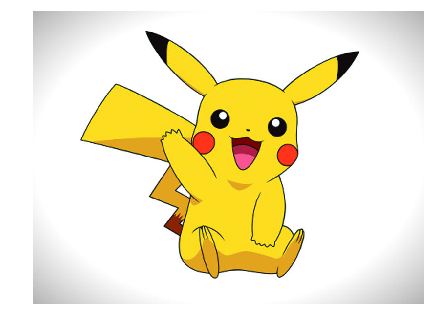

In [129]:
! wget 'https://cdn.ndtv.com/tech/images/gadgets/pikachu_hi_pokemon.jpg'
apply_model_to_image_raw_bytes(open("pikachu_hi_pokemon.jpg", "rb").read())

#### 7)

--2018-06-03 09:40:59--  https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Aristotle_Altemps_Inv8575.jpg/1200px-Aristotle_Altemps_Inv8575.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255831 (250K) [image/jpeg]
Saving to: ‘1200px-Aristotle_Altemps_Inv8575.jpg.1’

1200px-Aristotle_Al 100%[=====================>] 249.83K  --.-KB/s   in 0.004s 

2018-06-03 09:40:59 (59.9 MB/s) - ‘1200px-Aristotle_Altemps_Inv8575.jpg.1’ saved [255831/255831]

a man in a suit and tie standing next to a fire hydrant


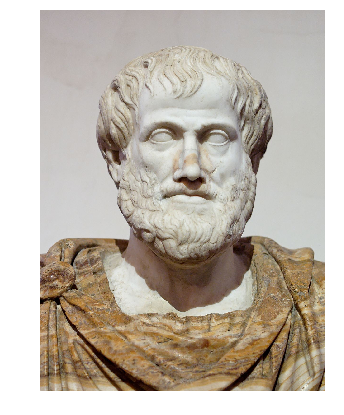

In [130]:
! wget 'https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Aristotle_Altemps_Inv8575.jpg/1200px-Aristotle_Altemps_Inv8575.jpg'
apply_model_to_image_raw_bytes(open("1200px-Aristotle_Altemps_Inv8575.jpg", "rb").read())

#### 8)

--2018-06-03 09:42:31--  https://www.nasa.gov/centers/goddard/images/content/638831main_globe_east_2048.jpg
Resolving www.nasa.gov (www.nasa.gov)... 69.28.157.200, 2607:f4e8:320:a000::e
Connecting to www.nasa.gov (www.nasa.gov)|69.28.157.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 536295 (524K) [image/jpeg]
Saving to: ‘638831main_globe_east_2048.jpg’

638831main_globe_ea 100%[=====================>] 523.73K  --.-KB/s   in 0.01s  

2018-06-03 09:42:31 (41.8 MB/s) - ‘638831main_globe_east_2048.jpg’ saved [536295/536295]

a close up of a plane on a clear day


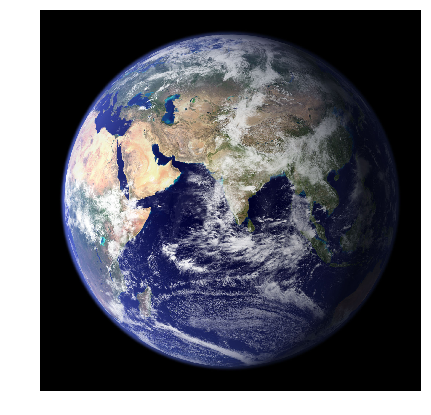

In [132]:
! wget 'https://www.nasa.gov/centers/goddard/images/content/638831main_globe_east_2048.jpg'
apply_model_to_image_raw_bytes(open("638831main_globe_east_2048.jpg", "rb").read())

#### 9)

--2018-06-03 09:43:10--  http://www.guinnessworldrecords.com/Images/First-men-on-the-Moon_tcm25-482521.jpg
Resolving www.guinnessworldrecords.com (www.guinnessworldrecords.com)... 217.64.230.80
Connecting to www.guinnessworldrecords.com (www.guinnessworldrecords.com)|217.64.230.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119062 (116K) [image/jpeg]
Saving to: ‘First-men-on-the-Moon_tcm25-482521.jpg’

First-men-on-the-Mo 100%[=====================>] 116.27K   389KB/s   in 0.3s   

2018-06-03 09:43:11 (389 KB/s) - ‘First-men-on-the-Moon_tcm25-482521.jpg’ saved [119062/119062]

a man in a red jacket and a black jacket on a snowboard


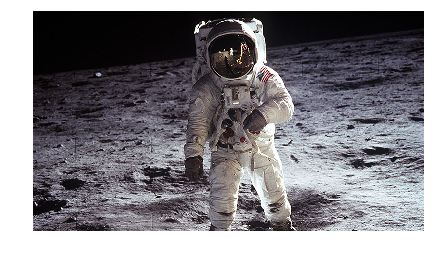

In [133]:
! wget 'http://www.guinnessworldrecords.com/Images/First-men-on-the-Moon_tcm25-482521.jpg'
apply_model_to_image_raw_bytes(open("First-men-on-the-Moon_tcm25-482521.jpg", "rb").read())

#### 10)

--2018-06-03 09:45:43--  https://cdn3.img.ria.ru/images/150041/06/1500410623.jpg
Resolving cdn3.img.ria.ru (cdn3.img.ria.ru)... 46.229.162.166
Connecting to cdn3.img.ria.ru (cdn3.img.ria.ru)|46.229.162.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53371 (52K) [image/jpeg]
Saving to: ‘1500410623.jpg’

1500410623.jpg      100%[=====================>]  52.12K  --.-KB/s   in 0.1s   

2018-06-03 09:45:45 (428 KB/s) - ‘1500410623.jpg’ saved [53371/53371]

a man riding a horse in a dirt field


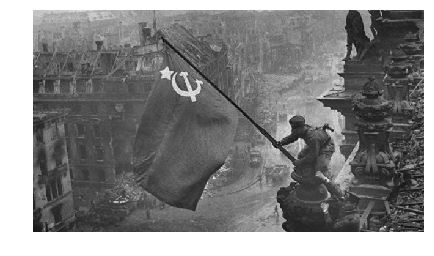

In [135]:
! wget 'https://cdn3.img.ria.ru/images/150041/06/1500410623.jpg'
apply_model_to_image_raw_bytes(open("1500410623.jpg", "rb").read())